In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def conv_forward(A_prev, W, b, activation, padding="same", stride=(1, 1)):
    """
    Perform Froward propagation over a convolution layer.

    A_prev is a numpy.ndarray of shape (m, h_prev, w_prev, c_prev)
        containing the output of the previous layer
        m is the number of examples
        h_prev is the height of the previous layer
        w_prev is the width of the previous layer
        c_prev is the number of channels in the previous layer

    W is a numpy.ndarray of shape (kh, kw, c_prev, c_new)
    containing the kernels for the convolution
        kh is the filter height
        kw is the filter width
        c_prev is the number of channels in the previous layer
        c_new is the number of channels in the output

    b is a numpy.ndarray of shape (1, 1, 1, c_new) containing
    the biases applied to the convolution

    activation is an activation function applied to the convolution

    padding is a string that is either same or valid,
    indicating the type of padding used

    stride is a tuple of (sh, sw) containing the strides for the convolution
        sh is the stride for the height
        sw is the stride for the width
    """
    m, h, w, _ = A_prev.shape
    kh, kw, _, nc = W.shape
    sh, sw = stride
    if padding == 'valid':
        ph, pw = 0, 0
    else:
        ph = int(np.ceil((sh*(h-1)-h+kh)/2))
        pw = int(np.ceil((sw*(w-1)-w+kw)/2))
    oh = int((h+2*pw-kh)/sh+1)
    ow = int((w+2*pw-kw)/sw+1)
    npad = ((0, 0), (ph, ph), (pw, pw), (0, 0))
    A_pad = np.pad(A_prev, pad_width=npad, mode='constant')
    output = np.zeros((m, oh, ow, nc))
    for k in range(nc):
        filterk = W[:, :, :, k]
        for i in range(oh):
            for j in range(ow):
                x = i * sh
                y = j * sw
                to_conv = A_pad[:, x:x+kh, y:y+kw, :]
                output[:, i, j, k] = np.tensordot(to_conv, filterk, axes=3)

    output = activation(output + b)
    return output




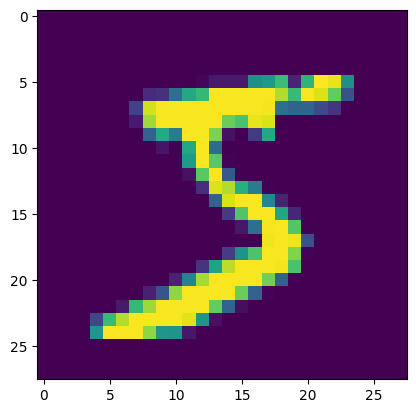

(50000, 28, 28, 2)


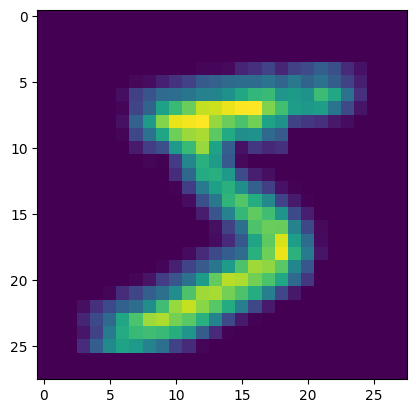

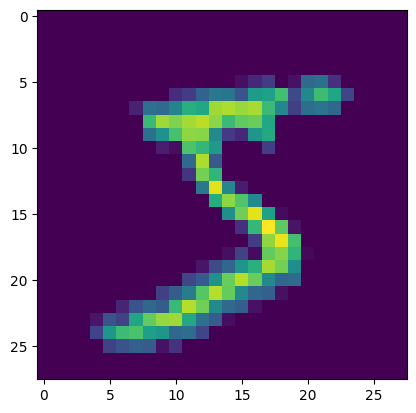

In [8]:

np.random.seed(0)
lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
m, h, w = X_train.shape
X_train_c = X_train.reshape((-1, h, w, 1))

W = np.random.randn(3, 3, 1, 2)
b = np.random.randn(1, 1, 1, 2)

def relu(Z):
    return np.maximum(Z, 0)

plt.imshow(X_train[0])
plt.show()
A = conv_forward(X_train_c, W, b, relu, padding='same')
print(A.shape)
plt.imshow(A[0, :, :, 0])
plt.show()
plt.imshow(A[0, :, :, 1])
plt.show()

In [9]:

def pool_forward(A_prev, kernel_shape, stride=(1, 1), mode='max'):
    """
    Perform forward propagation.

    A_prev is a numpy.ndarray of shape (m, h_prev, w_prev, c_prev)
    containing the output of the previous layer
        m is the number of examples
        h_prev is the height of the previous layer
        w_prev is the width of the previous layer
        c_prev is the number of channels in the previous layer
    kernel_shape is a tuple of (kh, kw) containing the
    size of the kernel for the pooling
        kh is the kernel height
        kw is the kernel width
    stride is a tuple of (sh, sw) containing the strides for the pooling
        sh is the stride for the height
        sw is the stride for the width
    mode is a string containing either max or avg, indicating whether
    to perform maximum or average pooling, respectively
    """
    kh, kw = kernel_shape
    sh, sw = stride
    m, h, w, c = A_prev.shape
    if mode == 'max':
        func = np.max
    elif mode == 'avg':
        func = np.average

    oh = int((h-kh)/sh+1)
    ow = int((w-kw)/sw+1)
    output = np.zeros((m, oh, ow, c))
    for i in range(0, oh):
        x = i * sh
        for j in range(0, ow):
            y = j * sw
            output[:, i, j, :] = func(A_prev[:, x:x+kh, y:y+kw], axis=(1, 2))

    return output

(50000, 28, 28, 2)


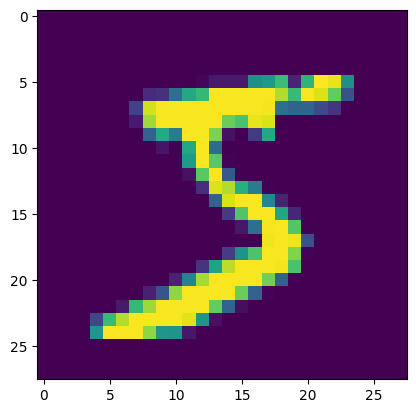

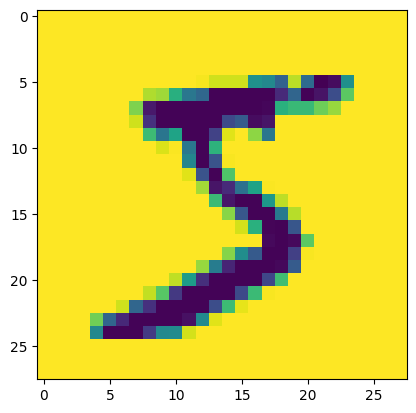

(50000, 14, 14, 2)


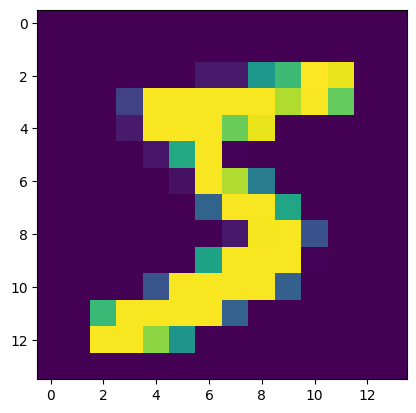

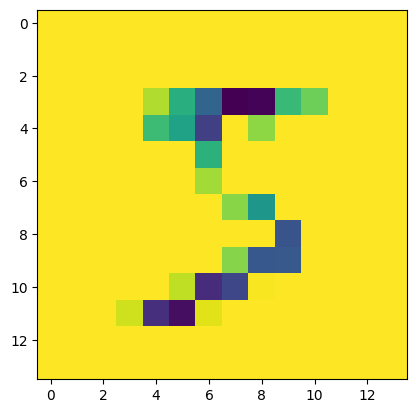

In [10]:
np.random.seed(0)
lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
m, h, w = X_train.shape
X_train_a = X_train.reshape((-1, h, w, 1))
X_train_b = 1 - X_train_a
X_train_c = np.concatenate((X_train_a, X_train_b), axis=3)

print(X_train_c.shape)
plt.imshow(X_train_c[0, :, :, 0])
plt.show()
plt.imshow(X_train_c[0, :, :, 1])
plt.show()
A = pool_forward(X_train_c, (2, 2), stride=(2, 2))
print(A.shape)
plt.imshow(A[0, :, :, 0])
plt.show()
plt.imshow(A[0, :, :, 1])
plt.show()


In [16]:

def conv_backward(dZ, A_prev, W, b, padding="same", stride=(1, 1)):
    """Backward propagation for Conv layer."""
    m, prev_h, prev_w, _ = A_prev.shape
    m, new_h, new_w, new_c = dZ.shape
    sh, sw = stride
    kh, kw, _, new_c = W.shape
    if padding == 'valid':
        ph, pw = 0, 0
    else:
        ph = int(np.ceil((sh*(prev_h-1)-prev_h+kh)/2))
        pw = int(np.ceil((sw*(prev_w-1)-prev_w+kw)/2))
    npad = ((0, 0), (ph, ph), (pw, pw), (0, 0))
    A_prev = np.pad(A_prev, pad_width=npad, mode='constant')
    dw = np.zeros_like(W)
    dA = np.zeros_like(A_prev)
    db = np.sum(dZ, axis=(0, 1, 2), keepdims=True)
    for img in range(m):
        for h in range(new_h):
            for w in range(new_w):
                x = h * sh
                y = w * sw
                for f in range(new_c):
                    filt = W[:, :, :, f]
                    dz = dZ[img, h, w, f]
                    slice_A = A_prev[img, x:x+kh, y:y+kw,:]
                    dw[:, :, :, f] += slice_A * dz
                    dA[img, x:x+kh, y:y+kw,:] += dz * filt
                    
    if padding == 'same':
        dA = dA[:, ph:-ph, pw:-pw, :]
    return dA, dw, db


In [17]:
np.random.seed(0)
lib = np.load('../data/MNIST.npz')
X_train = lib['X_train']
_, h, w = X_train.shape
X_train_c = X_train[:10].reshape((-1, h, w, 1))

W = np.random.randn(3, 3, 1, 2)
b = np.random.randn(1, 1, 1, 2)

dZ = np.random.randn(10, h - 2, w - 2, 2)
print(conv_backward(dZ, X_train_c, W, b, padding="valid"))

(array([[[[-4.2420573 ],
         [ 0.19390953],
         [-2.8016887 ],
         ...,
         [-2.9305928 ],
         [-0.7425718 ],
         [ 1.2355667 ]],

        [[-1.0086578 ],
         [ 0.24929619],
         [ 2.9915395 ],
         ...,
         [ 0.4335789 ],
         [ 4.9641595 ],
         [-0.44667327]],

        [[-1.8790928 ],
         [-1.5289836 ],
         [-1.039887  ],
         ...,
         [-2.087198  ],
         [ 0.72118443],
         [ 0.43712848]],

        ...,

        [[-1.8598138 ],
         [-4.3554325 ],
         [ 3.576361  ],
         ...,
         [ 2.111363  ],
         [ 0.5395872 ],
         [-3.5200026 ]],

        [[-1.0499573 ],
         [-2.0469675 ],
         [-3.651379  ],
         ...,
         [-0.5275695 ],
         [-0.08825486],
         [ 0.6215888 ]],

        [[-0.333836  ],
         [-0.68426305],
         [-1.1673741 ],
         ...,
         [ 0.38028386],
         [ 0.90910953],
         [ 1.1018033 ]]],


       [[[ 1.3242862 ],